In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import properscoring as ps
import scipy.integrate as integrate
from statsmodels.distributions.empirical_distribution import ECDF
from plotting import *

from shapely.ops import triangulate

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt

## Example

In [2]:
nex = pd.read_csv('../combine/output/nex_yield_60-05.csv')
nex['GEOID'] = nex["GEOID"].astype(str).str.zfill(5)
cmip = pd.read_csv('../combine/output/cmip_yield_60-05.csv')
cmip['GEOID'] = cmip["GEOID"].astype(str).str.zfill(5)

In [3]:
nexdat = nex.query('GEOID == "17019"').drop(columns = ['GEOID', 'Year', 'GMFD', 'USDA', 'ensemble_mean']).to_numpy().flatten()
cmipdat = cmip.query('GEOID == "17019"').drop(columns = ['GEOID', 'Year', 'GMFD', 'USDA', 'ensemble_mean']).to_numpy().flatten()
pdf = ss.gaussian_kde(nexdat)
cpdf = ss.gaussian_kde(cmipdat)

In [4]:
np.linspace(0.01, 0.3, 30)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ])

In [5]:
%%time
nexgrid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 0.3, 30)})
cmipgrid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 0.3, 30)})

CPU times: user 345 µs, sys: 26 µs, total: 371 µs
Wall time: 359 µs


In [6]:
%%time
nexgrid.fit(nexdat[:, None]);
cmipgrid.fit(cmipdat[:, None]);

CPU times: user 2.7 s, sys: 19.5 ms, total: 2.72 s
Wall time: 2.78 s


GridSearchCV(cv=None, error_score=nan,
             estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0,
                                     breadth_first=True, kernel='gaussian',
                                     leaf_size=40, metric='euclidean',
                                     metric_params=None, rtol=0),
             iid='deprecated', n_jobs=None,
             param_grid={'bandwidth': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [7]:
print(nexgrid.best_params_)
print(cmipgrid.best_params_)

{'bandwidth': 0.019999999999999997}
{'bandwidth': 0.06999999999999999}


In [8]:
%%time
nex_kde_skl = KernelDensity(bandwidth=nexgrid.best_params_['bandwidth']);
nex_kde_skl.fit(nexdat[:, np.newaxis]);

cmip_kde_skl = KernelDensity(bandwidth=cmipgrid.best_params_['bandwidth']);
cmip_kde_skl.fit(cmipdat[:, np.newaxis]);

CPU times: user 2.79 ms, sys: 398 µs, total: 3.18 ms
Wall time: 3.14 ms


KernelDensity(algorithm='auto', atol=0, bandwidth=0.06999999999999999,
              breadth_first=True, kernel='gaussian', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

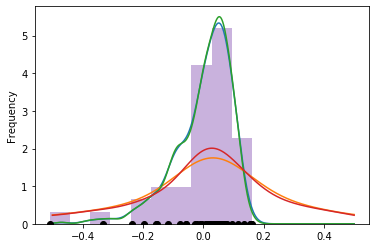

In [9]:
xgrid = np.linspace(-1/2,1/2,1000)
plt.plot(xgrid, pdf.evaluate(xgrid))
plt.plot(xgrid, cpdf.evaluate(xgrid))
plt.plot(xgrid, np.exp(nex_kde_skl.score_samples(xgrid[:,None])))
plt.plot(xgrid, np.exp(cmip_kde_skl.score_samples(xgrid[:,None])))
nex.query('GEOID == "17019"')['GMFD'].plot(kind = 'hist', density = True, alpha = 0.5)
plt.plot(cmip.query('GEOID == "17019"').filter(['GMFD']), np.zeros(cmip.query('GEOID == "17019"').filter(['GMFD']).shape), 'o', color = 'black', label = 'GMFD')
plt.show()

In [10]:
%%time
sampDist = [nex_kde_skl.sample(n_samples = 46).flatten() for i in range(1000)]
CsampDist = [cmip_kde_skl.sample(n_samples = 46).flatten() for i in range(1000)]
# sampDist = [pdf.resample(size = 46)[0] for i in range(10000)]
# CsampDist = [cpdf.resample(size = 46)[0] for i in range(10000)]

CPU times: user 130 ms, sys: 5.76 ms, total: 136 ms
Wall time: 146 ms


NEX: 0.854
CMIP: 0.0


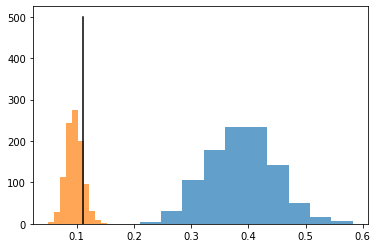

CPU times: user 253 ms, sys: 9.63 ms, total: 263 ms
Wall time: 271 ms


In [11]:
%%time
sampDist1 = np.array([np.std(x) for x in sampDist])
CsampDist1 = np.array([np.std(x) for x in CsampDist])
val = np.std(nex.query('GEOID == "17141"')['GMFD'])
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)
print('NEX: ' + str(nex_ecdf(val)))
print('CMIP: ' + str(cmip_ecdf(val)))

fig, ax = plt.subplots(1,1)
ax.hist(CsampDist1, alpha=0.7)
ax.hist(sampDist1, alpha=0.7)
ax.plot([val,val], [0,500], '-', color = 'black')
plt.show()

NEX: 0.872
CMIP: 0.0


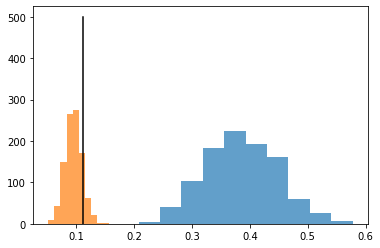

CPU times: user 263 ms, sys: 10.3 ms, total: 273 ms
Wall time: 292 ms


In [17]:
%%time
sampDist1 = np.array([np.std(x) for x in sampDist])
CsampDist1 = np.array([np.std(x) for x in CsampDist])
val = np.std(nex.query('GEOID == "17141"')['GMFD'])
nex_ecdf = ECDF(sampDist1)
cmip_ecdf = ECDF(CsampDist1)
print('NEX: ' + str(nex_ecdf(val)))
print('CMIP: ' + str(cmip_ecdf(val)))

fig, ax = plt.subplots(1,1)
ax.hist(CsampDist1, alpha=0.7)
ax.hist(sampDist1, alpha=0.7)
ax.plot([val,val], [0,500], '-', color = 'black')
plt.show()

## Best bandwidth results

In [52]:
# Read and store
bandwidths = np.loadtxt('./tail_pvals/python_iqr.txt')
bandwidths = [bandwidths[3*i:3*i+3] for i in range(int(len(bandwidths)/3))]
bandwidths = pd.DataFrame(bandwidths, columns = ['GEOID', 'nex_bw', 'cmip_bw'])
bandwidths['GEOID'] = bandwidths['GEOID'].astype(int).astype(str).str.zfill(5)
bandwidths.set_index('GEOID', inplace=True)

In [61]:
bandwidths

,nex_bw,cmip_bw
GEOID,,
01001,0.09,0.13
01003,0.03,0.05
01005,0.04,0.05
01007,0.06,0.10
01009,0.10,0.12
...,...,...
56027,0.02,0.22
56029,0.01,0.02
56031,0.01,0.17


# Results

In [3]:
nexIQR = pd.read_csv('./tail_pvals/nex_iqr_pval_60-05.csv')
nexIQR['GEOID'] = nexIQR["GEOID"].astype(str).str.zfill(5)
cmipIQR = pd.read_csv('./tail_pvals/cmip_iqr_pval_60-05.csv')
cmipIQR['GEOID'] = cmipIQR["GEOID"].astype(str).str.zfill(5)

nex80QR = pd.read_csv('./tail_pvals/nex_80qr_pval_60-05.csv')
nex80QR['GEOID'] = nex80QR["GEOID"].astype(str).str.zfill(5)
cmip80QR = pd.read_csv('./tail_pvals/cmip_80qr_pval_60-05.csv')
cmip80QR['GEOID'] = cmip80QR["GEOID"].astype(str).str.zfill(5)

nexSD = pd.read_csv('./tail_pvals/nex_sd_pval_60-05.csv')
nexSD['GEOID'] = nexSD["GEOID"].astype(str).str.zfill(5)
cmipSD = pd.read_csv('./tail_pvals/cmip_sd_pval_60-05.csv')
cmipSD['GEOID'] = cmipSD["GEOID"].astype(str).str.zfill(5)

nexMIN = pd.read_csv('./tail_pvals/nex_min_pval_60-05.csv')
nexMIN['GEOID'] = nexMIN["GEOID"].astype(str).str.zfill(5)
cmipMIN = pd.read_csv('./tail_pvals/cmip_min_pval_60-05.csv')
cmipMIN['GEOID'] = cmipMIN["GEOID"].astype(str).str.zfill(5)

nexMAD = pd.read_csv('./tail_pvals/nex_mad_pval_60-05.csv')
nexMAD['GEOID'] = nexMAD["GEOID"].astype(str).str.zfill(5)
cmipMAD = pd.read_csv('./tail_pvals/cmip_mad_pval_60-05.csv')
cmipMAD['GEOID'] = cmipMAD["GEOID"].astype(str).str.zfill(5)

In [4]:
# Add state FIPS
nexSD['state'] = nexSD['GEOID'].str[:2]

In [5]:
# Filter
StateDrop = ['53', '41', '16', '06', '04', '49', '56', '30', '08', '35'] # 10 westernmost CONUS states
StateKeep = nexSD['state'].unique()
locs = [np.where(StateKeep == drop) for drop in StateDrop]
StateKeep = np.delete(StateKeep, locs)
nexSD.set_index('state', inplace=True)
nexSD = nexSD.loc[StateKeep]

In [6]:
nexSD.head()

,GEOID,gmfd_sd,usda_sd
state,,,
01,01001,0.0621,0.9316
01,01003,0.0082,1.0000
01,01005,0.1214,0.9566
01,01007,0.0945,0.9997
01,01009,0.5635,0.9667


In [7]:
# Import plotting shapefiles
county_shp = gp.read_file('../../data/conus_shp/conus_plot/final/counties_contig_plot.shp')
county_shp["GEOID"] = county_shp["GEOID"].astype(str).str.zfill(5)

states = gp.read_file('../../data/conus_shp/conus_plot/final/states_contig_plot.shp')
coast = gp.read_file('../../data/conus_shp/conus_plot/final/coast_contig_plot.shp') 

In [59]:
# Filter
county_shp['area'] = county_shp['geometry'].apply(lambda x: x.area)
county_shp = county_shp.query('area > 10e3')

county_shp_plot = county_shp.copy()
county_shp_plot['state'] = county_shp_plot['GEOID'].str[:2]
county_shp_plot.set_index(['state'], inplace=True)
county_shp_plot = county_shp_plot.loc[StateKeep]

# states_plot = states.copy()
# states_plot.set_index(['STATEFP'], inplace=True)
# states_plot = states_plot.loc[StateKeep]

In [76]:
def PlotYield(data, model, title, vmin, vmax, cmap, save=False):
    """
    Plots the county-level map of a pre-calculated verification metric for one model

    Inputs:
        - data: Pandas DataFrame of pre-calculated verification metric for all models
        - model: String of model name to be plotted
        - metric: String of metric (to be used in plot asthetics)
        - vmin/vmax : Min/Max values to be plotted
        - cmap: Colormap to use in plot ('batlow' or 'broc')
        - save: Boolean, savefig or not
    """
    # Merge county-level shapefile with data
    data = data.reset_index()
    data['GEOID'] = data["GEOID"].astype(str).str.zfill(5)
    data.set_index(['GEOID'], inplace=True)
    data_shp = pd.merge(county_shp_plot, data.filter([model]), on="GEOID", how="inner", copy=False)
    # Do the plot!
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cax.tick_params(labelsize=20)
    data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=globals()[cmap + '_map'], vmin=vmin, vmax=vmax)
#     data_shp[data_shp[model].isna()].plot(ax=ax, color="lightgray")
    sig95_plot.plot(color = 'white', markersize=1, marker = 'o', ax = ax)
    sig5_plot.plot(color = 'black', markersize=1, marker = 'o', ax = ax)
    states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
    coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_xlim([-750000,2600000])
    ax.set_title(title, fontsize=20)
    plt.tight_layout()
    if save:
        plt.savefig('./test.png', dpi=500)
    else:
        plt.show()

In [70]:
sig5_plot = pd.merge(county_shp_plot, nexSD.query('gmfd_sd >= 0.95'), on="GEOID", how='inner', copy=False)
sig5_plot['geometry'] = sig5_plot['geometry'].apply(lambda x: x.centroid)

sig95_plot = pd.merge(county_shp_plot, nexSD.query('gmfd_sd <= 0.05'), on="GEOID", how='inner', copy=False)
sig95_plot['geometry'] = sig95_plot['geometry'].apply(lambda x: x.centroid)

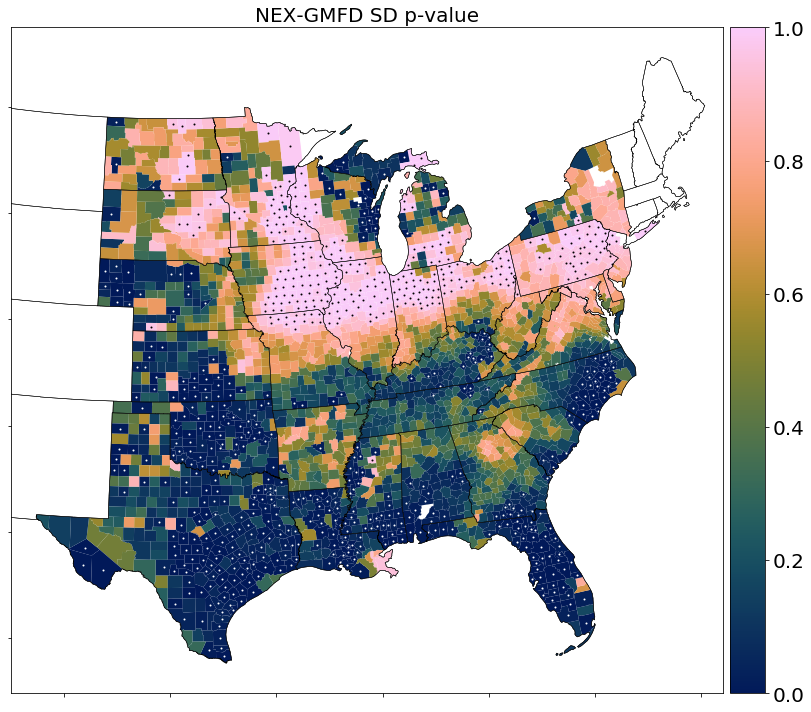

In [77]:
PlotYield(nexSD, 'gmfd_sd', 'NEX-GMFD SD p-value', 0., 1., 'batlow', save=True)

In [152]:
#################################################################################################

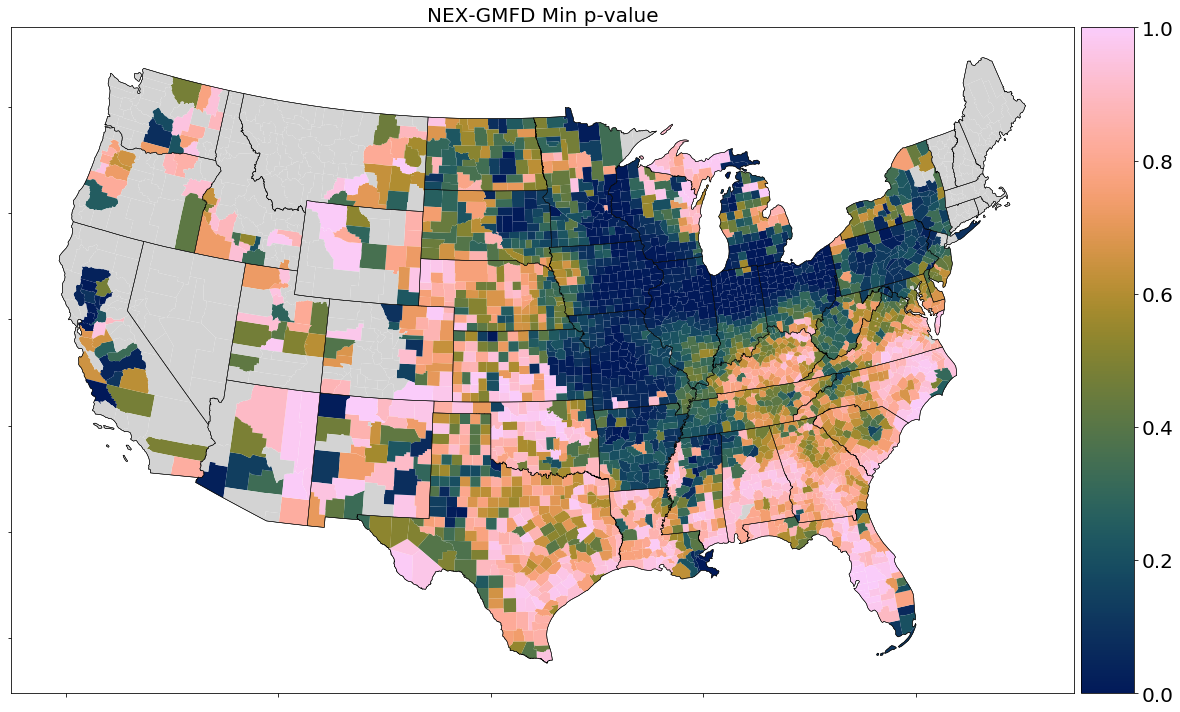

In [106]:
PlotYield(nexMIN, 'gmfd_min', 'NEX-GMFD Min p-value', 0., 1., 'batlow')

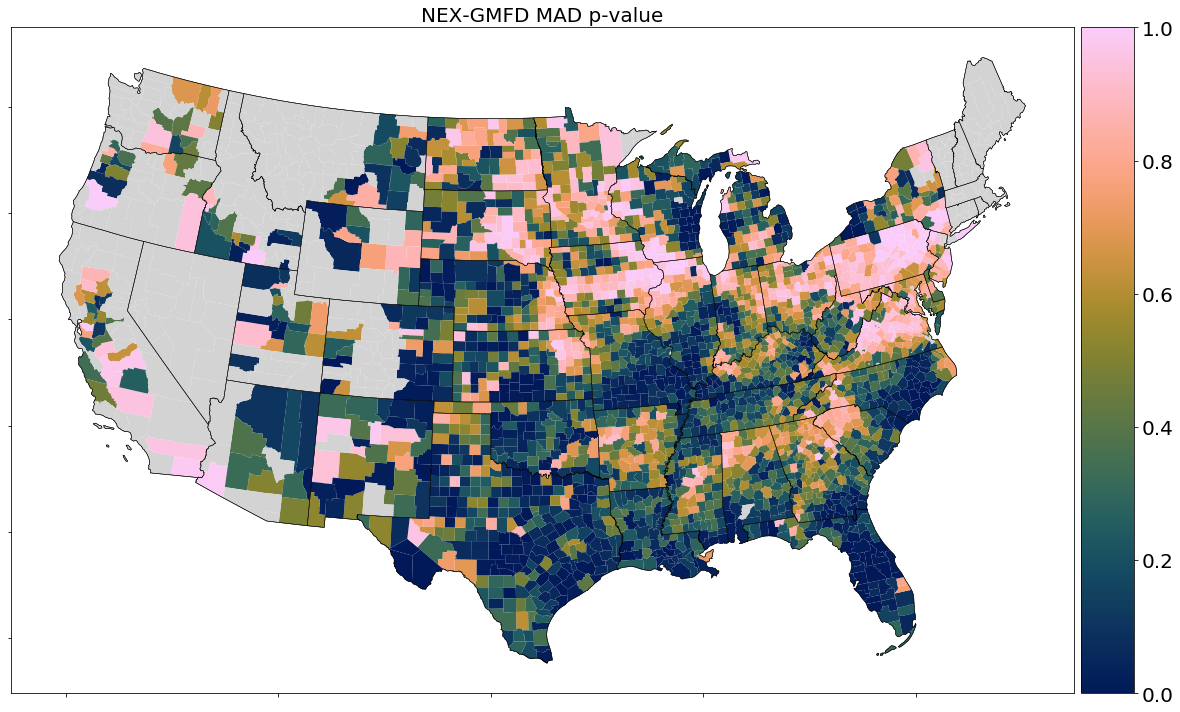

In [9]:
PlotYield(nexMAD, 'gmfd_mad', 'NEX-GMFD MAD p-value', 0., 1., 'batlow')

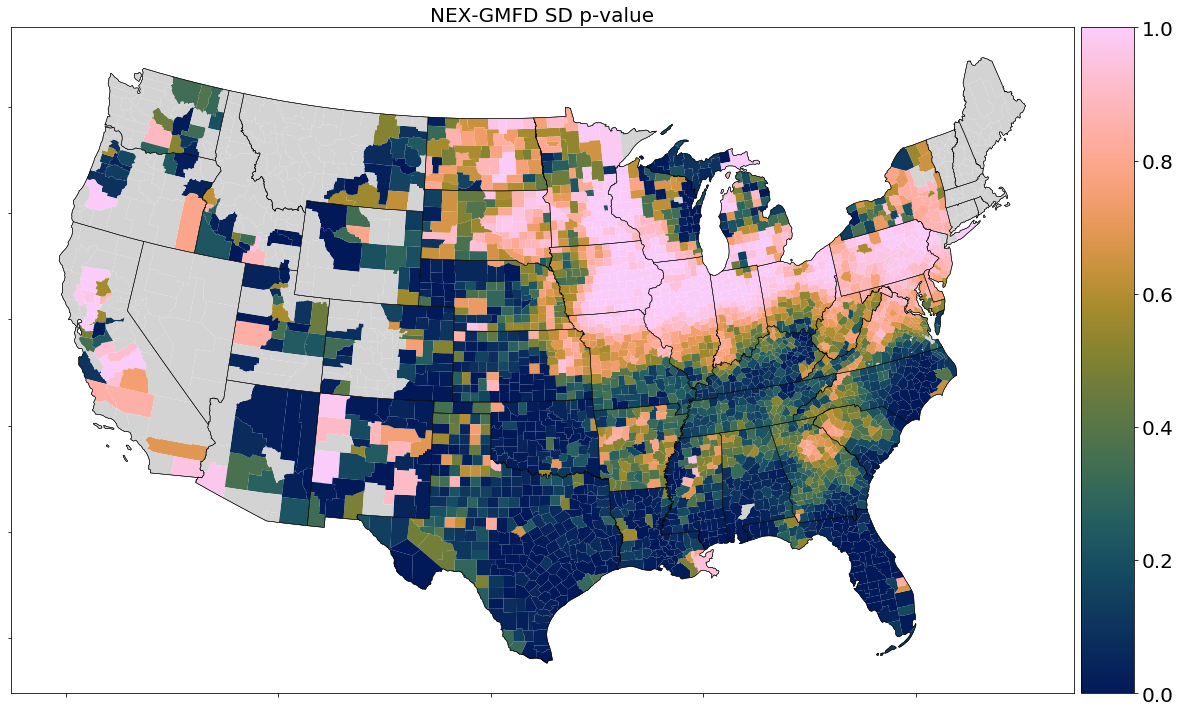

In [5]:
PlotYield(nexSD, 'gmfd_sd', 'NEX-GMFD SD p-value', 0., 1., 'batlow')

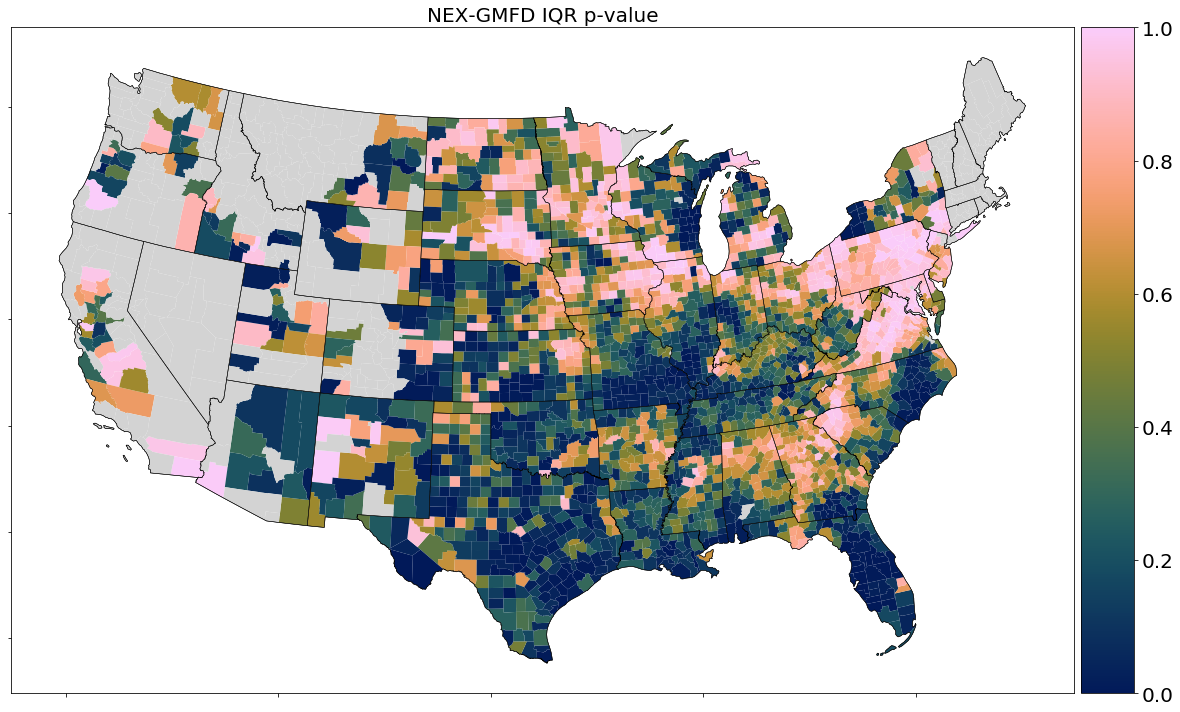

In [8]:
PlotYield(nexIQR, 'gmfd_iqr', 'NEX-GMFD IQR p-value', 0., 1., 'batlow')

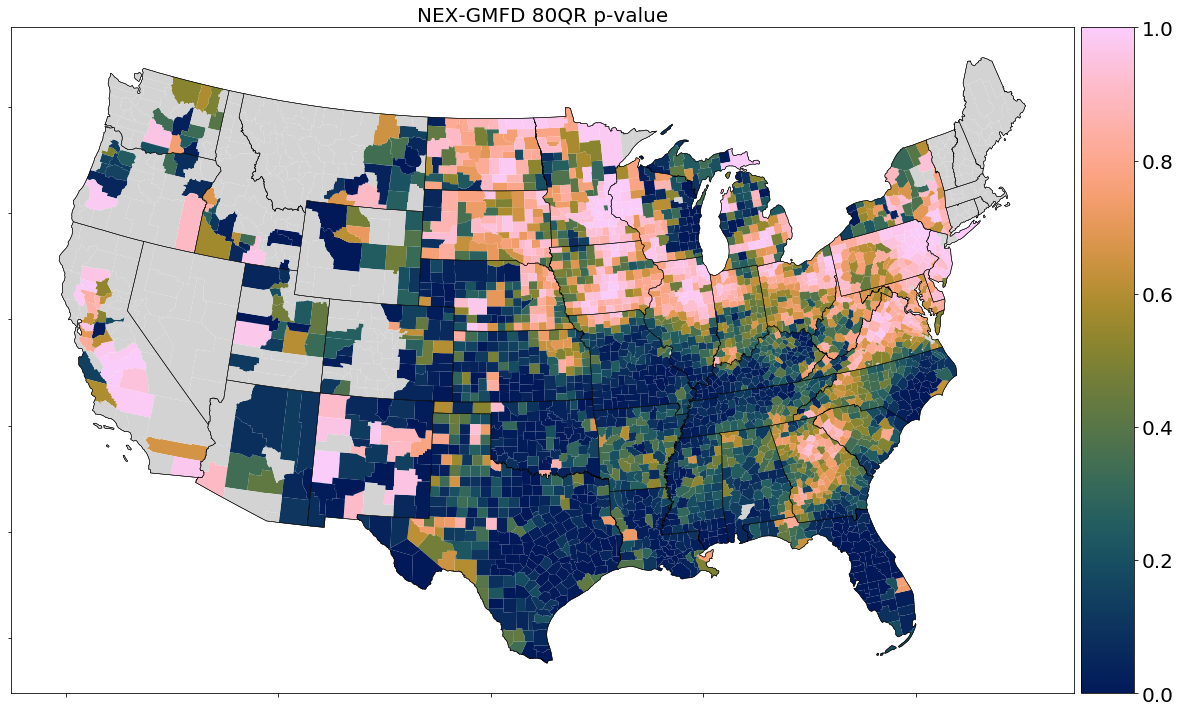

In [67]:
PlotYield(nex80QR, 'gmfd_80qr', 'NEX-GMFD 80QR p-value', 0., 1., 'batlow')